In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from keras.optimizers import Adam
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
import os
import pickle
from classifier_objects import Airfoil



2024-03-05 13:36:23.441643: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 13:36:23.473180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 13:36:23.473203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 13:36:23.474210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 13:36:23.480361: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 13:36:23.481580: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
def prepare_design_matrix(data_path, selection='all', num_samples=None, randomize=False, **kwargs):
    """
    Function to prepare the design matrix from data stored in objects.

    Parameters:
    - data_path (str): Path to the directory containing the data objects.
    - selection (str): Selection method for data. Options: 'all', 'random', 'specified'.
    - num_samples (int): Number of samples to select if selection is 'random'. Ignored if selection is 'all'.
    - randomize (bool): Whether to randomly select samples. Applicable only if selection is 'random'.
    - kwargs (dict): Additional keyword arguments for specifying data selection criteria.

    Returns:
    - design_matrix (numpy.ndarray): Processed design matrix.
    """


    data_objects = []
    for filename in os.listdir(data_path):
        if filename.endswith('.pkl'):
            file_path = os.path.join(data_path, filename)
            data_objects.append(file_path)  
    
    if selection == 'all':
        selected_data = data_objects
    elif selection == 'random':
        if randomize:
            np.random.shuffle(data_objects)  
        selected_data = data_objects
    elif selection == 'specified':
        pass 

    for file_path in selected_data:
        with open(file_path, 'rb') as f:
            airfoil = pickle.load(f)
            m_list = [float(airfoil.name[4])]         #m = max camber
            p_list = [float(airfoil.name[5])]         #p = location of max camber
            t_list = [float(airfoil.name[6:])]        #t = thickness
            keys_list = list(airfoil.polars.keys())
            for key in keys_list:
                if key == 0:
                    pass
                else:
                    data = airfoil.polars[key]
                    AoA = data[:,0] 
                    [float(i) for i in AoA]
                    Cl = data[:,1]
                    Cd = data[:,2]
                    Cm = data[:,3]
                    
                    input_data_matrix = np.array([AoA, [float(key)] * len(AoA), m_list * len(AoA), p_list * len(AoA), t_list * len(AoA)]).T
                    output_data_matrix = np.array([Cl, Cd, Cm]).T
                    num_input_rows, num_input_cols = input_data_matrix.shape
                    num_output_rows, num_output_cols = output_data_matrix.shape
                    if num_input_rows != num_output_rows:
                        UserWarning 

                    with open('input_data.txt', 'a') as f:
                        np.savetxt(f, input_data_matrix, fmt='%f', delimiter='\t')
                    with open('output_data.txt', 'a') as f:
                        np.savetxt(f, output_data_matrix, fmt='%f', delimiter='\t')

    return None


data_path = '../data/airfoil_data/NACAxxxx_pkl/'
prepare_design_matrix(data_path, selection='all', num_samples=None, randomize=False)


Epoch 1/100


/home/sari/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


650/650 - 3s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - 3s/epoch - 4ms/step
Epoch 2/100
650/650 - 2s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - 2s/epoch - 3ms/step
Epoch 3/100
650/650 - 2s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.1555e-04 - val_mean_squared_error: 9.1555e-04 - 2s/epoch - 3ms/step
Epoch 4/100
650/650 - 2s - loss: 8.1704e-04 - mean_squared_error: 8.1704e-04 - val_loss: 6.8313e-04 - val_mean_squared_error: 6.8313e-04 - 2s/epoch - 3ms/step
Epoch 5/100
650/650 - 2s - loss: 6.9906e-04 - mean_squared_error: 6.9906e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - 2s/epoch - 3ms/step
Epoch 6/100
650/650 - 2s - loss: 6.4736e-04 - mean_squared_error: 6.4736e-04 - val_loss: 5.1204e-04 - val_mean_squared_error: 5.1204e-04 - 2s/epoch - 4ms/step
Epoch 7/100
650/650 - 2s - loss: 5.7789e-04 - mean_squared_error: 5.7789e-04 - val_loss: 4.9001e-04 - val_

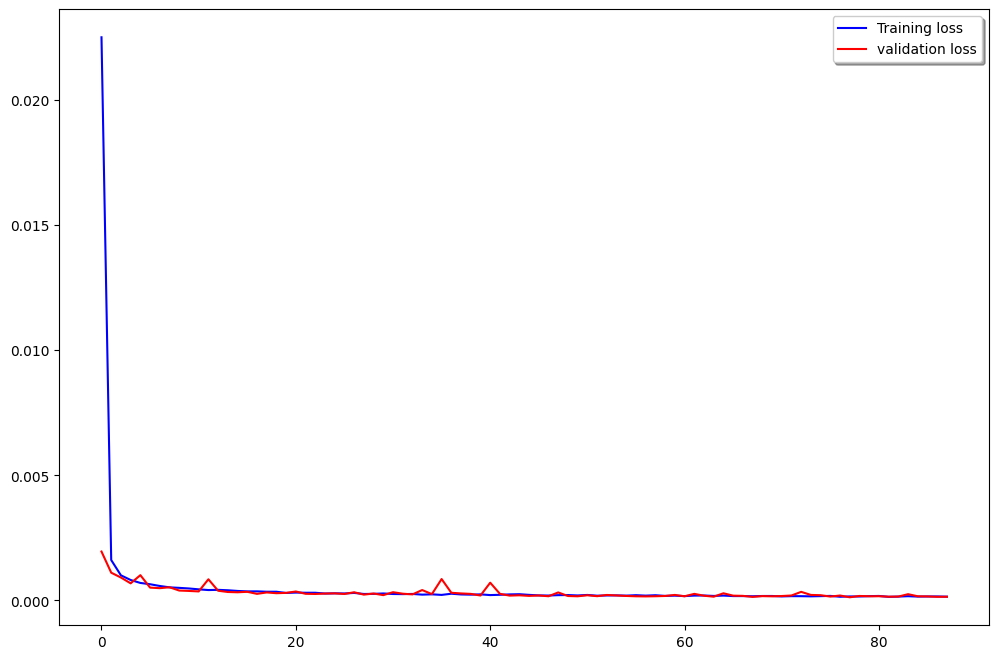

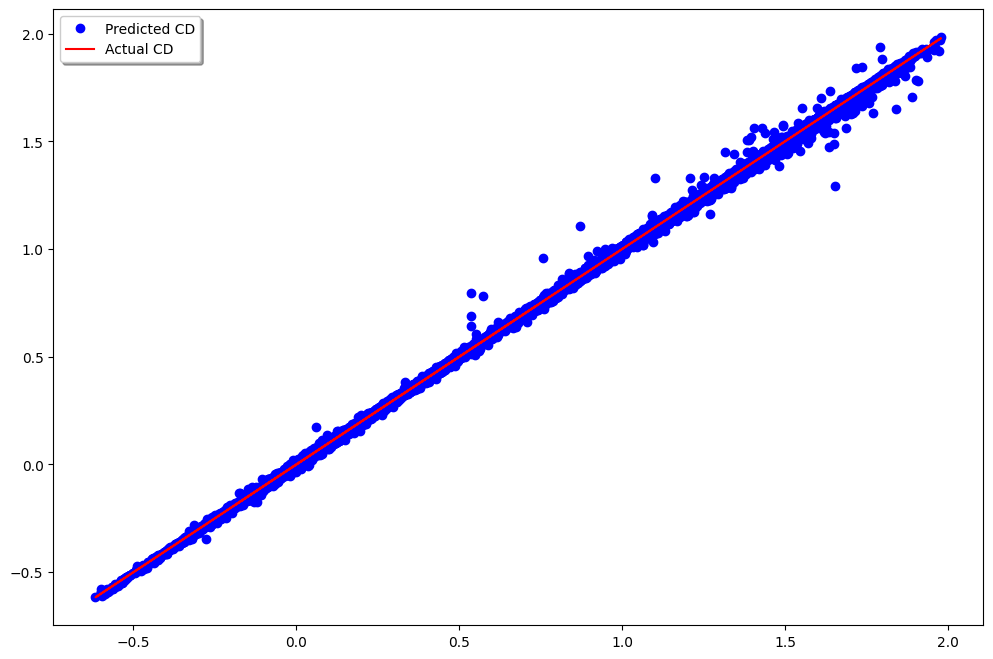

In [4]:
# Load dataset
x = np.loadtxt('input_data.txt')
DM = np.loadtxt('output_data.txt')

CD = DM[:,2]

x = x/np.amax(x, axis=0) # Normalize the data

# Split the dataset into training, validation and test sets
x_train, x_test, CD_train, CD_test = train_test_split(x, CD, test_size=0.1, random_state=42)
x_train, x_val, CD_train, CD_val = train_test_split(x_train, CD_train, test_size=0.1, random_state=42)

# Create the model
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=5))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="linear"))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])


# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(x_train, CD_train, epochs=100, batch_size=256, validation_data=(x_val, CD_val), callbacks=[early_stopping], verbose=2)

# Evaluate the model
scores = model.evaluate(x_test, CD_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax.legend(loc='best', shadow=True)

# Predict the CD
CD_pred = model.predict(x_test)

# Plot the predicted CD vs the actual CD
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(CD_test, CD_pred, 'o', color='b', label="Predicted CD")
ax.plot(CD_test, CD_test, '-', color='r', label="Actual CD")
legend = ax.legend(loc='best', shadow=True)

# Calculate the R2 score
r2 = r2_score(CD_test, CD_pred)
print("R2 score: ", r2)

# Calculate the mean squared error
mse = np.mean((CD_test - CD_pred)**2)
print("Mean squared error: ", mse)


model.save('MLP4regression_CL.h5')